In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import ta
from ta.trend import macd

In [2]:
# apple stock price değerleri
df = yf.download("AAPL",start="2018-01-01", end="2022-01-01")

# adjusted close
df = df[["Adj Close"]]

df

[*********************100%***********************]  1 of 1 completed


,Adj Close
Date,
2018-01-02,41.075409
2018-01-03,41.068256
2018-01-04,41.259014
2018-01-05,41.728760
2018-01-08,41.573769
...,...
2021-12-27,179.836319
2021-12-28,178.799164
2021-12-29,178.888916


In [3]:
def feature_engineering(df):
 
    
    # yedeklenip nan değerleri sil
    df_copy = df.dropna().copy()
    
    # return oluşturuldu
    df_copy["returns"] = df_copy["Adj Close"].pct_change(1)

    # simple moving average
    df_copy["SMA 30"] = df_copy[["Adj Close"]].rolling(30).mean().shift(1)
    
    # relative strength index
    RSI = ta.momentum.RSIIndicator(df_copy["Adj Close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    # moving average convergence divergence
    df_copy["macd"] = macd(df_copy["Adj Close"], window_slow = 26, window_fast = 12)
    
    df_copy["Price_Rise"] = np.where(df_copy["Adj Close"].shift(-1) > df_copy["Adj Close"], 1, 0)

    
    return df_copy.dropna()

In [4]:
dfc = feature_engineering(df)
dfc.head(10)

,Adj Close,returns,SMA 30,rsi,macd,Price_Rise
Date,,,,,,
2018-02-14,40.072094,0.018437,40.552651,51.377787,-0.694405,1
2018-02-15,41.417652,0.033578,40.519208,58.601445,-0.460387,0
2018-02-16,41.283577,-0.003237,40.530854,57.681860,-0.282489,0
2018-02-20,41.144714,-0.003364,40.531673,56.689637,-0.150968,0
2018-02-21,40.957966,-0.004539,40.512205,55.311656,-0.061101,1
2018-02-22,41.300335,0.008359,40.491678,57.358092,0.037315,1
2018-02-23,42.018600,0.017391,40.482722,61.356237,0.171294,1
2018-02-26,42.849396,0.019772,40.498027,65.397550,0.340585,0
2018-02-27,42.710541,-0.003241,40.533156,64.189297,0.458263,0


In [5]:
dfc.columns

Index(['Adj Close', 'returns', 'SMA 30', 'rsi', 'macd', 'Price_Rise'], dtype='object')

In [6]:
# train set'in yüzdesi
split = int(0.80*len(dfc))

# train setler
X_train = dfc[["SMA 30", "rsi" , "macd"]].iloc[:split]
y_train = dfc[["Price_Rise"]].iloc[:split]


# test setler
X_test = dfc[["SMA 30", "rsi", "macd"]].iloc[split:]
y_test = dfc[["Price_Rise"]].iloc[split:]

In [7]:
# class'ın tanımlanması
reg = LinearRegression()

# model'i fit et
reg.fit(X_train, y_train)

LinearRegression()

In [8]:
# data set için tahmin yapılması
X = np.concatenate((X_train, X_test), axis=0)

dfc["prediction"] = reg.predict(X)

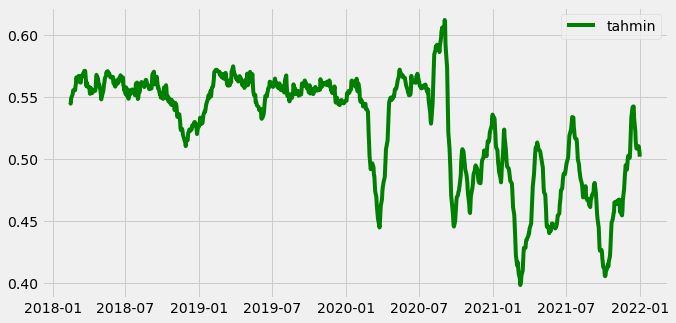

In [9]:
plt.figure(figsize=(10,5))
plt.plot(dfc["prediction"], color='g', label="tahmin")
plt.legend()
plt.show()

In [10]:
# tahminlerin yerlerini hesaplama
dfc["position"] = np.sign(dfc["prediction"])

# return'ü hesapla
dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

dfc["strategy"] = dfc["strategy"].iloc[split:].cumsum()*100

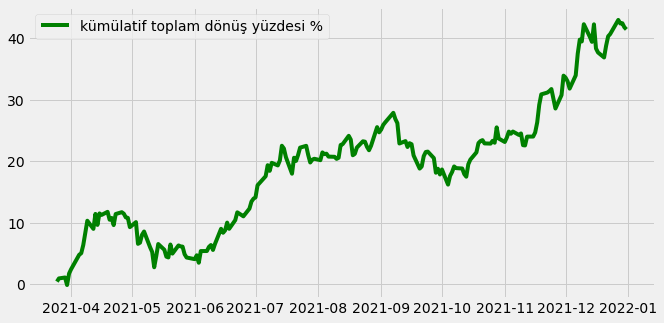

In [11]:
plt.figure(figsize=(10,5))
plt.plot(dfc["strategy"], color='g', label="kümülatif toplam dönüş yüzdesi %")
plt.legend()
plt.show()

In [12]:
def lin_reg_trading(symbol):

      def feature_engineering(df):

        # yedeklenip nan değerleri sil
        df_copy = df.dropna().copy()

        # return oluşturuldu
        df_copy["returns"] = df_copy["Adj Close"].pct_change(1)

        # simple moving average
        df_copy["SMA 30"] = df_copy[["Adj Close"]].rolling(30).mean().shift(1)

        # relative strength index
        RSI = ta.momentum.RSIIndicator(df_copy["Adj Close"], window= 14, fillna = False)
        df_copy["rsi"] = RSI.rsi()

        # moving average convergence divergence
        df_copy["macd"] = macd(df_copy["Adj Close"], window_slow = 26, window_fast = 12)
        
        df_copy["Price_Rise"] = np.where(df_copy["Adj Close"].shift(-1) > df_copy["Adj Close"], 1, 0)

        return df_copy.dropna()
  

      # verileri al
      df = yf.download(symbol)

      # adjusted close
      df = df[["Adj Close"]]

      dfc = feature_engineering(df)

      # train set'in yüzdesi
      split = int(0.80*len(dfc))

      # train set 
      X_train = dfc[["SMA 30", "rsi", "macd"]].iloc[:split]
      y_train = dfc[["Price_Rise"]].iloc[:split]


      # test set
      X_test = dfc[["SMA 30", "rsi", "macd"]].iloc[split:]
      y_test = dfc[["Price_Rise"]].iloc[split:]

      # linear regression'u tanımla
      reg = LinearRegression()

      # model'i fit et 
      reg.fit(X_train, y_train)

      # datasette tahminlerde bulun
      X = np.concatenate((X_train, X_test), axis=0)

      dfc["prediction"] = reg.predict(X)

      # pozisyonu hesapla
      dfc["position"] = np.sign(dfc["prediction"])

      # return hesapla
      dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)


      (dfc["strategy"].iloc[split:].cumsum()*100).plot()

[*********************100%***********************]  1 of 1 completed


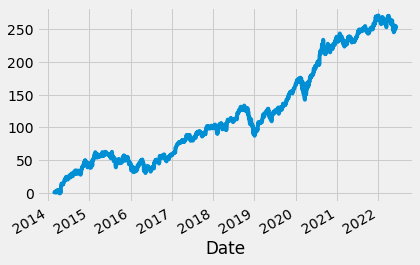

In [13]:
lin_reg_trading("AAPL")

In [14]:
#Backtesting
#sortino beta alpha algoritması
#sharp ratio'ya benziyor ama sadece negatif değerlerle ilgilenir. çünkü para kazandıkça ne olduğunun önemi yoktur.

In [15]:
#sortino 
#0'dan küçükse:kazanç negatif. 
#1'den küçükse: kar edilir ama risklidir, getirisi götürüsünden fazla olabilir
#1'den büyükse: risk düşüktür, yatırımlar karlıdır
# dataları çek
f = yf.download("AAPL",start="2018-01-01", end="2022-01-01")
return_serie = f["Adj Close"].pct_change(1).dropna()
return_serie.name = "return"

# sortino hesapla
mean = np.mean(return_serie) #252
vol = np.std(return_serie[return_serie<0]) #sqrt(252)
sortino = np.sqrt(252) * mean/vol

print(f"Sortino: {'%.3f' % sortino}")

[*********************100%***********************]  1 of 1 completed
Sortino: 1.708


In [16]:
#beta
#kendi elimizdeki hisse senedi ile piyasadaki genel durumu karşılaştırır
#beta <1: elimizdek, hissenin daha az varyasyona sahip olduğu anlamına gelmektedir
#beta >1: iyi değildir. elimizdeki hisse senetlerindeki çeşitliliğin fazla olduğu anlamına gelmektedir

In [17]:
# market fiyatları çekilir
sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
sp500.name = "SP500"

# alınan verileri birleştir
val = pd.concat((return_serie, sp500), axis=1).dropna()

# beta yı hesapla
cov_var_mat = np.cov(val.values, rowvar=False)
cov = cov_var_mat[0][1]
var = cov_var_mat[1][1]

beta = cov/var

print(f"Beta: {'%.3f' % beta}")

[*********************100%***********************]  1 of 1 completed
Beta: 1.201


In [18]:
#alpha 
#piyasadaki risk getirisinden daha iyi peroformans gösterip göstermediğimizi hesaplar
#alpha >0 : piyasadan daha iyi performans sergilenmiş
# alpha <0: piyasadan daha kötü bir performans sergilenmiş

In [19]:
#alphayı hesapla
alpha = (252 * mean * (1-beta))*100
print(f"Alpha: {'%.1f' % alpha}")

Alpha: -8.4


In [20]:
def drawdown_function(serie):

  # cumulitve sum hesapla
  cum = serie.dropna().cumsum() + 1

  # periyottaki maksimim cumsum hesapla - maksimum birikim 
  running_max = np.maximum.accumulate(cum)

  # drawdown hesapla
  drawdown = cum/running_max - 1
  return drawdown

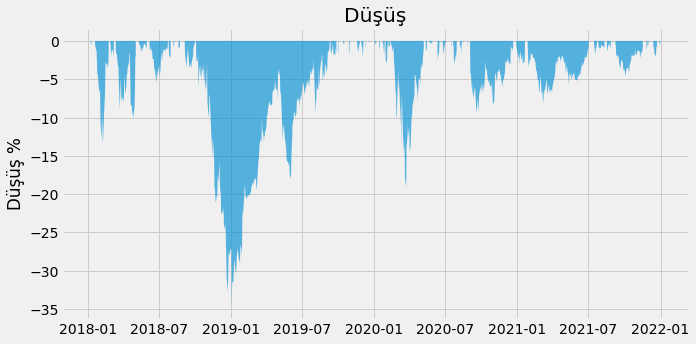

In [21]:
# drawdawn döndür
drawdown = drawdown_function(return_serie)

plt.figure(figsize=(10,5))
plt.fill_between(drawdown.index, drawdown*100, 0, drawdown, alpha=0.65)
plt.title("Düşüş")
plt.ylabel("Düşüş %")
plt.show()

In [22]:
# maksimum drawdown hesapla
max_drawdown = -np.min(drawdown)*100
print(f"Max drawdown: {'%.1f' % max_drawdown} %")

Max drawdown: 34.6 %


In [23]:
def BackTest(serie, annualiazed_scalar=252):

  # benchmark 
  sp500 = yf.download("^GSPC")["Adj Close"].pct_change(1)
  
  # ismi sp500 yap
  sp500.name = "SP500"

  # sp500 birleştir
  val = pd.concat((serie,sp500), axis=1).dropna()

  # drawdown hesapla
  drawdown = drawdown_function(serie)*100
  
  # maksimum drawdown
  max_drawdown = -np.min(drawdown)


  fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6))
  fig.suptitle("Backtesting", size=20)
  cum.plot(serie.cumsum()*100, color="green")
  cum.plot(val["SP500"].cumsum()*100, color="red")
  cum.legend(["Cüzdan", "SP500"])
  cum.set_title("Kümülatif Toplam", size=13)
  cum.set_ylabel("Kümülatif Toplam %", size=11)
  dra.fill_between(drawdown.index,0,drawdown, color="blue", alpha=0.65)
  dra.set_title("Düşüş", size=13)
  dra.set_ylabel("Düşüş %", size=11)
  plt.show()


  # sortino hesapla
  sortino = np.sqrt(annualiazed_scalar) * serie.mean()/serie.loc[serie<0].std()

  # beta hesapla
  beta = np.cov(val[["return", "SP500"]].values,rowvar=False)[0][1] / np.var(val["SP500"].values)

  # alpha hesapla
  alpha = annualiazed_scalar * (serie.mean() - beta*serie.mean())

  print(f"Sortino: {np.round(sortino,3)}")
  #print(f"Beta: {np.round(beta,3)}")
  #print(f"Alpha: {np.round(alpha*100,3)} %")
  print(f"Maksimum Düşüş: {np.round(max_drawdown,3)} %")

[*********************100%***********************]  1 of 1 completed


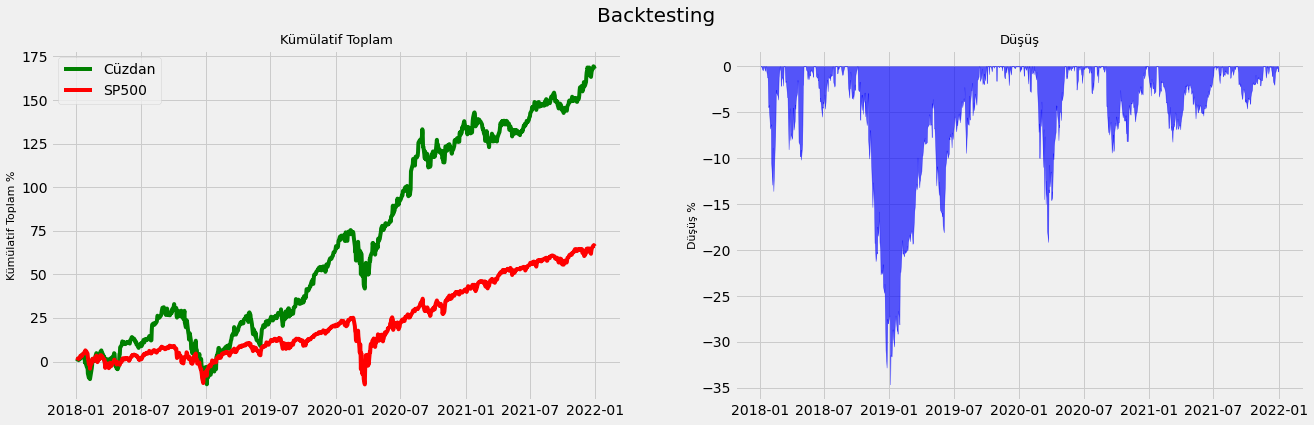

Sortino: 1.706
Maksimum Düşüş: 34.617 %


In [24]:
BackTest(return_serie, 252)

In [25]:
def lin_reg_trading(symbol):

  def feature_engineering(df):
    
    df_copy = df.dropna().copy()

    df_copy["returns"] = df_copy["Adj Close"].pct_change(1)

    df_copy["SMA 30"] = df_copy[["Adj Close"]].rolling(30).mean().shift(1)

    RSI = ta.momentum.RSIIndicator(df_copy["Adj Close"], window= 14, fillna = False)
    df_copy["rsi"] = RSI.rsi()
    
    df_copy["macd"] = macd(df_copy["Adj Close"], window_slow = 26, window_fast = 12)
    
    df_copy["Price_Rise"] = np.where(df_copy["Adj Close"].shift(-1) > df_copy["Adj Close"], 1, 0)
    
    return df_copy.dropna()
  

  df = yf.download(symbol)


  df = df[["Adj Close"]]

  dfc = feature_engineering(df)

  split = int(0.80*len(dfc))

  X_train = dfc[["SMA 30", "rsi", "macd"]].iloc[:split]
  y_train = dfc[["Price_Rise"]].iloc[:split]


  X_test = dfc[["SMA 30", "rsi", "macd"]].iloc[split:]
  y_test = dfc[["Price_Rise"]].iloc[split:]


  reg = LinearRegression()


  reg.fit(X_train, y_train)


  X = np.concatenate((X_train, X_test), axis=0)

  dfc["prediction"] = reg.predict(X)


  dfc["position"] = np.sign(dfc["prediction"])


  dfc["strategy"] = dfc["returns"] * dfc["position"].shift(1)

  dfc["return"] = dfc["strategy"]

  BackTest(dfc["return"].iloc[split:])

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


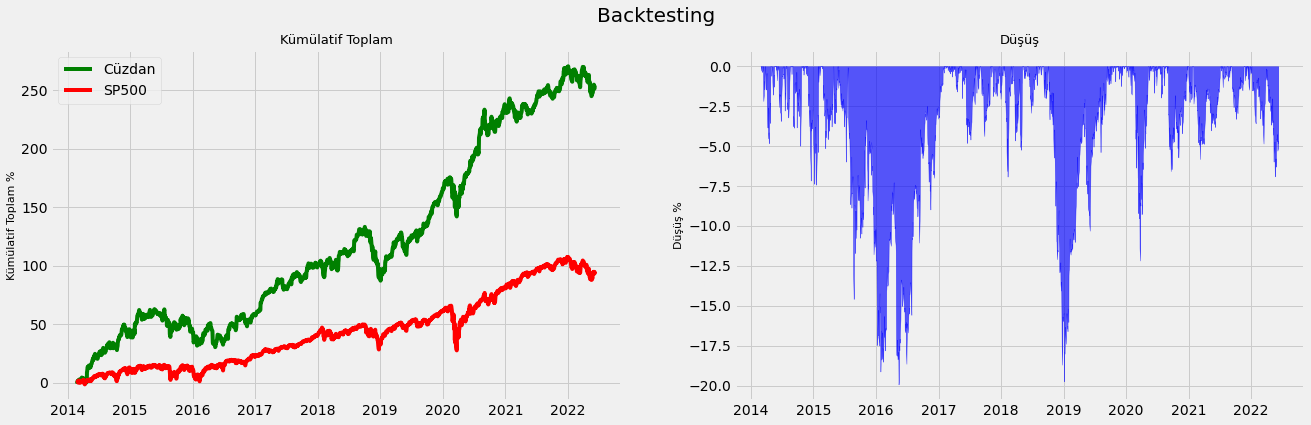

Sortino: 1.45
Maksimum Düşüş: 19.922 %


In [26]:
lin_reg_trading("AAPL")